# Introduction to sentiment analysis with NLI

In this notebook, you will implement a sentiment scoring pipeline using a Natural Language Inference (NLI) model.
You will analyze whether news headlines about S&P 500 companies have positive or negative sentiment and explore how this sentiment correlates with market returns.


## Install and Import librairies
Install necessary packages and import the required libraries for:
- Loading data
- Using transformer models
- Plotting and visualizing results
- Downloading financial data

In [1]:
%pip install hf_xet
%pip install yfinance
%pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 134.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import math
import matplotlib.pyplot as plt
import yfinance as yf

## Load news data
Load two datasets:
- `df_news.csv`: contains headlines and summaries
- `df_metadata.csv`: contains ticker symbols and company sector info

We drop duplicate summaries to avoid redundant sentiment scoring.

In [3]:
# We define the directory where the data is located
from google.colab import drive
drive.mount('/content/drive')
import os
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/Fintech//Data"
os.chdir(DIR)

Mounted at /content/drive


In [4]:
df_news = pd.read_csv('df_news.csv')
df_news.drop_duplicates('SUMMARY', inplace=True)
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23 10:30:00+00:00,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22 17:49:43+00:00,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21 18:14:38+00:00,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21 16:00:08+00:00,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


In [5]:
df_meta = pd.read_csv('df_metadata.csv')
display(df_meta)

,TICKER,COMPANY_NAME,SECTOR,INDUSTRY
0,MMM,3M Company,Industrials,Conglomerates
1,AOS,A. O. Smith Corporation,Industrials,Specialty Industrial Machinery
2,ABT,Abbott Laboratories,Healthcare,Medical Devices
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,ACN,Accenture plc,Technology,Information Technology Services
...,...,...,...,...
485,XEL,Xcel Energy Inc.,Utilities,Utilities - Regulated Electric
486,XYL,Xylem Inc.,Industrials,Specialty Industrial Machinery
487,YUM,"Yum! Brands, Inc.",Consumer Cyclical,Restaurants
488,ZBH,"Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices


## Sentiment Analysis with NLI

In this section, you will apply a CrossEncoder NLI model (`cross-encoder/nli-deberta-v3-base`) to estimate sentiment from news headlines.

👉 **Instructions**:

1. Use a CrossEncoder NLI model to compute how much a news headline implies a **positive** or **negative** sentiment.
2. For each news title, compute the probability of it being **positive** and **negative**, and store them in `POSITIVE_PROB` and `NEGATIVE_PROB`.
3. Derive a final sentiment score by subtracting: `SENTIMENT = POSITIVE_PROB - NEGATIVE_PROB`.

✅ This score will serve as your sentiment signal, ranging from negative to positive.

> ℹ️ You are free to decide how to structure the input pairs and how to apply the model.


In [6]:
from sentence_transformers import CrossEncoder
import torch

# Loading the CrossEncoder model
model = CrossEncoder('cross-encoder/nli-deberta-v3-base')

# Defining sentiment labels
labels = ['negative', 'neutral', 'positive']

# Creating input pairs for the model
# Each pair consists of the news title and a sentiment label
pairs_positive = [(title, 'This is positive.') for title in df_news['TITLE']]
pairs_negative = [(title, 'This is negative.') for title in df_news['TITLE']]

# Predicting scores for positive and negative sentiment using batching
batch_size = 32
scores_positive = model.predict(pairs_positive, batch_size=batch_size)
scores_negative = model.predict(pairs_negative, batch_size=batch_size)


# Converting scores to probabilities using softmax
def softmax(x):
    return torch.exp(torch.tensor(x)) / torch.sum(torch.exp(torch.tensor(x)))

positive_probs = [softmax(score)[labels.index('positive')] for score in scores_positive]
negative_probs = [softmax(score)[labels.index('negative')] for score in scores_negative]

# Storing probabilities in the DataFrame
df_news['POSITIVE_PROB'] = positive_probs
df_news['NEGATIVE_PROB'] = negative_probs

# Calculating the final sentiment score
df_news['SENTIMENT'] = df_news['POSITIVE_PROB'] - df_news['NEGATIVE_PROB']

display(df_news.head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,tensor(0.9875),tensor(0.9848),tensor(0.0026)
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,tensor(0.9958),tensor(0.0070),tensor(0.9888)
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,tensor(0.9985),tensor(0.9897),tensor(0.0087)
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,tensor(0.9998),tensor(0.0033),tensor(0.9965)
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...,tensor(0.9778),tensor(0.0003),tensor(0.9775)


## Compare Sentiment with Returns

In this section, you'll explore how daily news sentiment aligns with market behavior.

👉 **Instructions**:

1. Group the news data by **publication date** and compute the **average sentiment per day**.
2. Download **daily stock prices** for the relevant tickers using `yfinance`.
3. Compute **daily returns** and use their average as a proxy for the market (e.g., S\&P 500).
4. Visualize both **daily sentiment** and **daily returns** over time using line plots.
5. Create a **dual y-axis chart** to compare trends more effectively.

✅ This section helps you assess whether changes in sentiment coincide with market movements.

> ℹ️ Focus on trend relationships, not just visual similarity—this is an opportunity to start thinking about predictive signals.

/tmp/ipython-input-740028499.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  487 of 487 completed


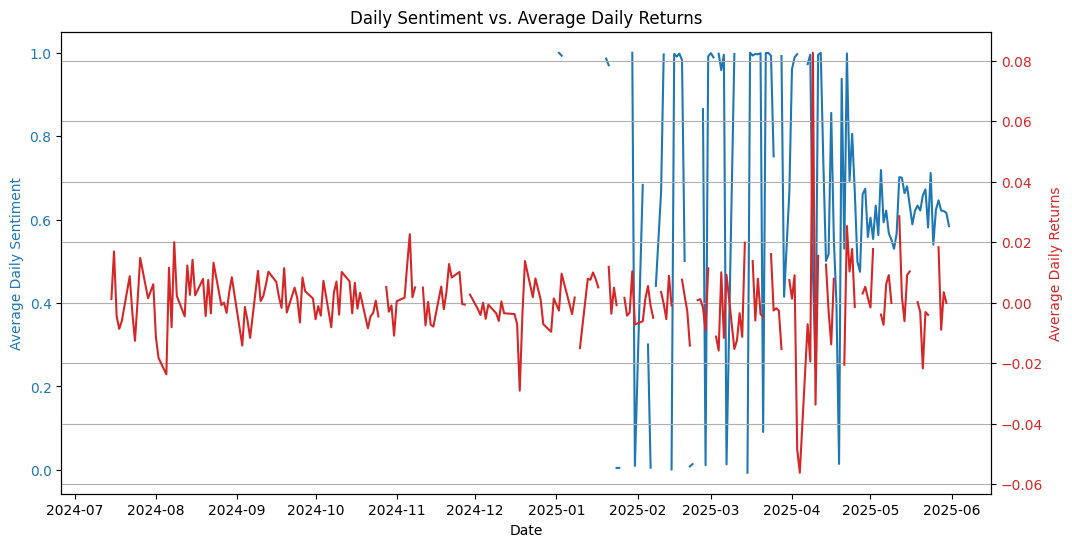

In [11]:
# Grouping news data by publication date and compute average sentiment
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
daily_sentiment = df_news.groupby('PUBLICATION_DATE')['SENTIMENT'].mean().reset_index()
daily_sentiment['PUBLICATION_DATE'] = pd.to_datetime(daily_sentiment['PUBLICATION_DATE'])
daily_sentiment.set_index('PUBLICATION_DATE', inplace=True)

# Getting unique tickers from the news data
tickers = df_news['TICKER'].unique().tolist()

# Downloading daily stock prices for the relevant tickers
# Defining the date range based on the news data
start_date = daily_sentiment.index.min()
end_date = daily_sentiment.index.max()

# Downloading data using yfinance
stock_data = yf.download(tickers, start=start_date, end=end_date)

# Computing daily returns using the 'Close' price
daily_returns = stock_data['Close'].pct_change().mean(axis=1)

# Combining sentiment and returns dataframes
comparison_df = pd.DataFrame({
    'Sentiment': daily_sentiment['SENTIMENT'],
    'Returns': daily_returns
})

# Visualizing daily sentiment and daily returns
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting daily sentiment
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Daily Sentiment', color=color)
ax1.plot(comparison_df.index, comparison_df['Sentiment'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for daily returns
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Daily Returns', color=color)
ax2.plot(comparison_df.index, comparison_df['Returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Daily Sentiment vs. Average Daily Returns')
plt.grid(True)
plt.show()

## Compare Daily Portfolio Value Against Daily Average Sentiment

In this section, you will simulate a simple market portfolio and explore how its performance aligns with daily sentiment scores.

👉 **Instructions**:

1. Simulate a **market portfolio** by computing the cumulative return of the average daily return across all tickers.
2. Start the portfolio with an **initial value of 1.0** and track its value over time.
3. Plot the **daily average sentiment** and the **portfolio value** using a dual-axis line chart.

✅ This visualization lets you explore whether market sentiment leads or lags behind portfolio movements.

> ℹ️ Think about how this setup could inform a basic trading strategy—or whether sentiment could serve as a timing signal.


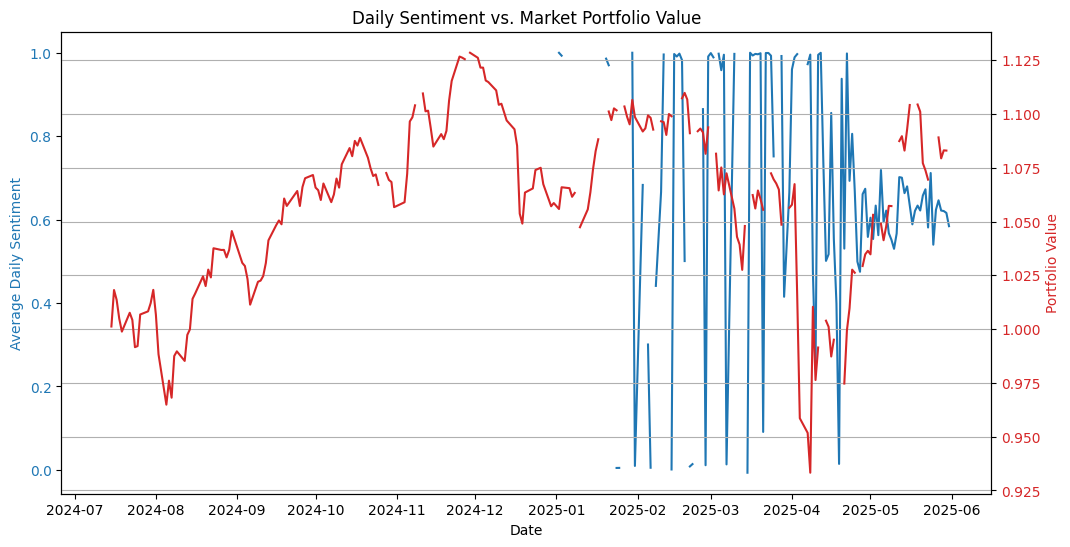

In [12]:
# Calculating the cumulative return of the average daily return
cumulative_returns = (1 + daily_returns).cumprod()

# Simulating portfolio value starting with an initial value of 1.0
initial_value = 1.0
portfolio_value = initial_value * cumulative_returns

# Combining sentiment and portfolio value dataframes
comparison_portfolio_df = pd.DataFrame({
    'Sentiment': daily_sentiment['SENTIMENT'],
    'Portfolio Value': portfolio_value
})

# Visualizing daily sentiment and portfolio value
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting daily sentiment
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Daily Sentiment', color=color)
ax1.plot(comparison_portfolio_df.index, comparison_portfolio_df['Sentiment'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for portfolio value
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Portfolio Value', color=color)
ax2.plot(comparison_portfolio_df.index, comparison_portfolio_df['Portfolio Value'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Daily Sentiment vs. Market Portfolio Value')
plt.grid(True)
plt.show()

## Compute Sector-Level Sentiment and Returns

In this section, you’ll analyze how sector-level news sentiment compares to market performance for May. You’ll also measure whether sentiment correlates with returns.

👉 **Instructions**:

1. Group companies by **sector** using the metadata.
2. For each sector:

   * Compute **monthly average sentiment** (Feb to May).
   * (Optional) Count the number of headlines per month.
3. Compute **monthly stock returns** from price data and extract **May returns**.
4. Build a comparison table with:

   * `SECTOR`
   * `SENTIMENT` (May sentiment)
   * `RETURN` (May return)
5. Compute and print the **correlation** between May sentiment and May returns.

✅ This step helps evaluate whether optimistic news coverage for a sector is associated with better performance.

> 💡 Once your analysis is complete, consider:
>
> * Which sectors *looked* good in the news but didn’t perform?
> * Which sectors performed well despite neutral/negative sentiment?
> * Would you invest based on sentiment alone? Why or why not?



In [19]:
# Merging news data with metadata to get sector information
df_merged = pd.merge(df_news, df_meta[['TICKER', 'SECTOR']], on='TICKER', how='left')

# Converting 'PUBLICATION_DATE' to datetime objects
df_merged['PUBLICATION_DATE'] = pd.to_datetime(df_merged['PUBLICATION_DATE'])

# Filtering data for the period Feb to May
df_filtered = df_merged[(df_merged['PUBLICATION_DATE'].dt.month >= 2) & (df_merged['PUBLICATION_DATE'].dt.month <= 5) & (df_merged['PUBLICATION_DATE'].dt.year == 2025)]

# Computing monthly average sentiment per sector
monthly_sentiment = df_filtered.groupby([df_filtered['PUBLICATION_DATE'].dt.to_period('M'), 'SECTOR'])['SENTIMENT'].mean().reset_index()
monthly_sentiment['PUBLICATION_DATE'] = monthly_sentiment['PUBLICATION_DATE'].dt.to_timestamp()


# Counting headlines per month per sector
headline_counts = df_filtered.groupby([df_filtered['PUBLICATION_DATE'].dt.to_period('M'), 'SECTOR']).size().reset_index(name='HEADLINE_COUNT')
headline_counts['PUBLICATION_DATE'] = headline_counts['PUBLICATION_DATE'].dt.to_timestamp()


# Computing monthly stock returns per sector
# Resampling stock data to get monthly closing prices
monthly_stock_data = stock_data['Close'].resample('M').ffill()

# Calculating monthly returns
monthly_returns = monthly_stock_data.pct_change()

# Reshaping monthly_returns for merging with sentiment data
monthly_returns_stacked = monthly_returns.stack().reset_index(name='MONTHLY_RETURN')
monthly_returns_stacked.rename(columns={'Date': 'PUBLICATION_DATE', 'Ticker': 'TICKER'}, inplace=True)

# Getting sector for each ticker in monthly_returns_stacked
ticker_to_sector = df_meta.set_index('TICKER')['SECTOR'].to_dict()
monthly_returns_stacked['SECTOR'] = monthly_returns_stacked['TICKER'].map(ticker_to_sector)

# Computing average monthly return per sector
sector_monthly_returns = monthly_returns_stacked.groupby(['PUBLICATION_DATE', 'SECTOR'])['MONTHLY_RETURN'].mean().reset_index()


# Filtering for May data for sentiment and returns
may_sentiment = monthly_sentiment[monthly_sentiment['PUBLICATION_DATE'].dt.month == 5]
may_returns = sector_monthly_returns[sector_monthly_returns['PUBLICATION_DATE'].dt.month == 5]

# Building the comparison table for May
comparison_table = pd.merge(may_sentiment, may_returns[['SECTOR', 'MONTHLY_RETURN']], on='SECTOR', how='left')
comparison_table.rename(columns={'SENTIMENT': 'MAY_SENTIMENT', 'MONTHLY_RETURN': 'MAY_RETURN'}, inplace=True)
comparison_table.drop('PUBLICATION_DATE', axis=1, inplace=True)

# Displaying the comparison table
display(comparison_table)

# Computing and print the correlation between May sentiment and May returns
correlation = comparison_table['MAY_SENTIMENT'].corr(comparison_table['MAY_RETURN'])
print(f"\nCorrelation between May Sentiment and May Returns: {correlation}")

/tmp/ipython-input-3620220970.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stock_data = stock_data['Close'].resample('M').ffill()


,SECTOR,MAY_SENTIMENT,MAY_RETURN
0,Basic Materials,0.56426,0.029613
1,Communication Services,0.704584,0.041527
2,Consumer Cyclical,0.643694,0.056382
3,Consumer Defensive,0.679537,0.000008
4,Energy,0.665379,0.029434
5,Financial Services,0.688437,0.061068
6,Healthcare,0.58249,0.000100
7,Industrials,0.625479,0.073894
8,Real Estate,0.497365,0.010360
9,Technology,0.600648,0.075285



Correlation between May Sentiment and May Returns: 0.2700173255281545


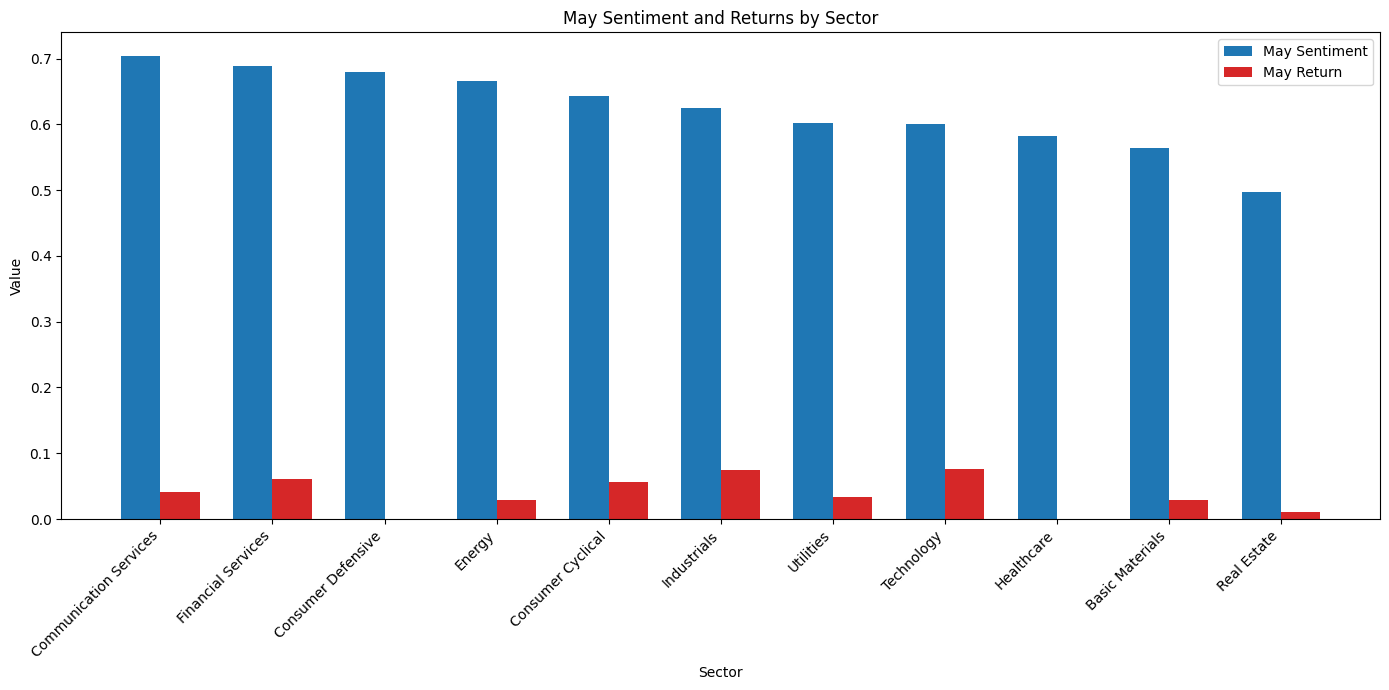

In [20]:
import matplotlib.pyplot as plt

# Sorting the table by May sentiment for better visualization
comparison_table_sorted = comparison_table.sort_values('MAY_SENTIMENT', ascending=False)

fig, ax = plt.subplots(figsize=(14, 7))

bar_width = 0.35
index = range(len(comparison_table_sorted))

# Plotting May Sentiment
bars1 = ax.bar(index, comparison_table_sorted['MAY_SENTIMENT'], bar_width, label='May Sentiment', color='tab:blue')

# Plotting May Returns
bars2 = ax.bar([i + bar_width for i in index], comparison_table_sorted['MAY_RETURN'], bar_width, label='May Return', color='tab:red')

ax.set_xlabel('Sector')
ax.set_ylabel('Value')
ax.set_title('May Sentiment and Returns by Sector')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(comparison_table_sorted['SECTOR'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

### **Question 1.** Which sectors *looked* good in the news? How did they perform?


YOUR WRITTEN RESPONSE HERE:
* Based on the May sentiment scores in comparison_table, sectors such as Communication Services and Financial Services experienced relatively high positive sentiment. In terms of performance, Financial Services exhibited very strong positive return, with Communication Services also posting a positive, albeit somewhat lesser, return. The Technology and Industrials sectors also performed well, despite their sentiment scores being more moderate compared to the top two.




### **Question 2.** Which sectors performed well despite neutral/negative sentiment?


YOUR WRITTEN RESPONSE HERE:
* On the basis of May sentiment and returns analysis, there were several sectors that performed well despite being nowhere near the sectors with the highest sentiment ratings. Notably, the Technology and Industrials sectors recorded significant positive returns, though their average sentiment was near neutral to moderately positive rather than being in the sectors which had the highest sentiment. This suggests that simply good news coverage was not the explanation for performance in these sectors during May.

### **Question 3.**  Would you invest based on sentiment alone? Why or why not?

YOUR WRITTEN RESPONSE HERE:
* Investing solely based on sentiment is usually not advisable. Sentiment could influence market direction in the short term, but it does not capture all the company's fundamentals, the overall economic climate, and other variables driving long-term growth. From the analysis, there were sectors with poor sentiment but performing well, thereby showing that sentiment is only one of the many pointers to be employed in an integrated investment plan.


### **Question 4.**  How would you go about testing a sentiment analysis strategy in a more robust way?

YOUR WRITTEN RESPONSE HERE:
* To stress test a sentiment approach more rigorously, one could conduct a backtest over a longer historical time frame, rather than one month. This would be done by generating trades from sentiment signals and evaluating performance against measures like Sharpe ratio, Sortino ratio, and maximum drawdown. Furthermore, combining other market data, fundamental analysis, or higher-order modeling strategies with sentiment could lead to a more informative and robust strategy evaluation.
